# SPKIR CG data deep dive 1.1

In this notebook we display OOI SPKIR data stored in the kdata drive for certain deployments that may need additional annotations. 
Ref Des: CP01CNSM-RID26-08-SPKIRB000

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm

from ooi_data_explorations.common import list_methods, list_streams, get_annotations, add_annotation_qc_flags, load_kdata, get_vocabulary, update_dataset
from ooi_data_explorations.uncabled.process_spkir import spkir_datalogger
from ooinet.M2M import get_deployments
from qartod_testing.data_deep_dive import nanfill_time_gaps

In [2]:
# Set parameters for data request 
refdes = 'CP01CNSM-RID26-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

### Check data delivery methods, deployments, and annotations

In [3]:
# Create dict of methods and associated data streams
methods = list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [4]:
# View deployment information
deployments = get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00238,2414,40.13678,-70.76978,7.0,2013-11-21 18:16:00,2014-04-18 10:33:00,KN214,KN217
1,2,CGINS-SPKIRB-00272,1395,40.1339,-70.7789,7.0,2014-12-13 18:47:00,2014-12-15 20:58:00,KN224,KN224
2,3,CGINS-SPKIRB-00272,1395,40.14022,-70.77128,7.0,2015-05-07 17:34:00,2015-10-23 19:40:00,AT27,AT31
3,4,CGINS-SPKIRB-00291,1335,40.13323,-70.77843,7.0,2015-10-23 18:49:00,2016-04-04 12:03:00,AT31,AR1-07
4,5,CGINS-SPKIRB-00270,1398,40.14037,-70.77133,7.0,2016-05-13 13:50:00,2016-10-13 19:34:00,AR4,AR8
5,6,CGINS-SPKIRB-00291,1335,40.13342,-70.77847,7.0,2016-10-13 18:36:00,2017-06-09 16:05:00,AR8,AR18
6,7,CGINS-SPKIRB-00270,1398,40.139817,-70.77115,7.0,2017-06-09 14:24:00,2017-11-01 20:33:00,AR18,AR24
7,8,CGINS-SPKIRB-00275,1409,40.133383,-70.7783,7.0,2017-10-29 14:15:00,2018-03-29 19:37:00,AR24,AR28
8,9,CGINS-SPKIRB-00299,1345,40.13975,-70.77128,7.0,2018-03-24 21:32:00,2018-10-29 12:31:00,AR28,AR31
9,10,CGINS-SPKIRB-00271,1400,40.133367,-70.7777,7.0,2018-10-30 01:48:00,2019-04-07 18:08:00,AR31,AR34


In [5]:
## View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations

# Note: now I have moved the lines that add a human-readable date time up here where the annotations are displayed, however I'm not sure if the begin and endDT columns still need 
# to exist. I would like to remove them because they are just taking up space and don't add anything to the dataFrame displayed below.

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,363,CP01CNSM,RID26,08-SPKIRB000,telemetered,None,1445626140000,1459771380000,Data not telemetered.,False,leila@marine.rutgers.edu,not_available,[],2015-10-23T18:49:00,2016-04-04T12:03:00
1,504,CP01CNSM,RID26,08-SPKIRB000,None,None,1385057700000,1397779200000,Data not recoverable.,False,leila@marine.rutgers.edu,None,[],2013-11-21T18:15:00,2014-04-18T00:00:00
2,103,CP01CNSM,None,None,None,None,1392595200000,1397779200000,Surface buoy exploded due to hydrogen build-up...,False,swhite@whoi.edu,not_operational,[],2014-02-17T00:00:00,2014-04-18T00:00:00
3,519,CP01CNSM,RID26,08-SPKIRB000,None,None,1418496420000,1418677080000,Data not recoverable.,False,leila@marine.rutgers.edu,None,[],2014-12-13T18:47:00,2014-12-15T20:58:00
4,1379,CP01CNSM,RID26,None,telemetered,None,1524504120000,1540864080000,Power down - Instrument Disabled.,False,leila@marine.rutgers.edu,not_operational,[],2018-04-23T17:22:00,2018-10-30T01:48:00
5,709,CP01CNSM,None,None,None,None,1418496420000,1418677080000,Deployment 2: Short deployment due to the fuel...,False,cdobson@whoi.edu,None,[],2014-12-13T18:47:00,2014-12-15T20:58:00
6,1773,CP01CNSM,RID26,08-SPKIRB000,None,None,1569609000000,1668172860000,The use of UV lamps has been implemented for b...,False,swhite@whoi.edu,None,[],2019-09-27T18:30:00,2022-11-11T13:21:00
7,2914,CP01CNSM,RID26,None,None,None,1626256800000,1627300800000,Deployment 14: * UPDATED 2021-07-26: NSIF powe...,False,cdobson@whoi.edu,not_operational,[],2021-07-14T10:00:00,2021-07-26T12:00:00
8,4253,CP01CNSM,RID26,None,telemetered,None,1657843200000,1658102400000,Deployment 16: A gap in telemetered data is pr...,False,cdobson@whoi.edu,None,[],2022-07-15T00:00:00,2022-07-18T00:00:00
9,4581,CP01CNSM,RID26,08-SPKIRB000,None,None,1649601300000,1668172860000,Deployment 16: The UV light failured during th...,False,cdobson@whoi.edu,None,[],2022-04-10T14:35:00,2022-11-11T13:21:00


### Deployment 1

In [7]:
# Set method and stream strings
method = methods[1]
stream = streams[method][0]
deploy = 1

In [81]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


In [11]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [82]:
spkir = nanfill_time_gaps(spkir)

In [83]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                     (time: 3120, station: 1)
Coordinates:
  * time                        (time) datetime64[ns] 2013-11-21T18:15:00 ......
Dimensions without coordinates: station
Data variables: (12/22)
    internal_temperature        (station, time) float32 17.5 17.5 ... 15.0 15.0
    input_voltage               (station, time) float32 8.52 8.49 ... 8.49 8.49
    deployment                  (station, time) float32 1.0 1.0 1.0 ... 1.0 1.0
    analog_rail_voltage         (station, time) float32 5.34 5.34 ... 5.34 5.34
    raw_irradiance_412          (station, time) float32 2.147e+09 ... 2.147e+09
    raw_irradiance_444          (station, time) float32 2.148e+09 ... 2.148e+09
    ...                          ...
    downwelling_irradiance_620  (station, time) float32 0.007838 ... 0.008446
    downwelling_irradiance_683  (station, time) float32 -0.005027 ... -0.008123
    station_name                (station) <U8 'CP01CNSM'
    lat                         (station) float32 40.14
    lon                         (station) float32 -70.77
    z                           (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             spkir_abj_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

Potentially adjust start date of existing annotation: current annotation that explains telemetered data is missing due to surface buoy exploding starts on 2014-02-17, but the available data only goes until 2013-12-24. Does the start date for the missing data annotation need to be moved up to this date? Where does date of explosion come from?

In [8]:
# Print annotation messaage below
annotations['annotation'][2]

'Surface buoy exploded due to hydrogen build-up in well.'

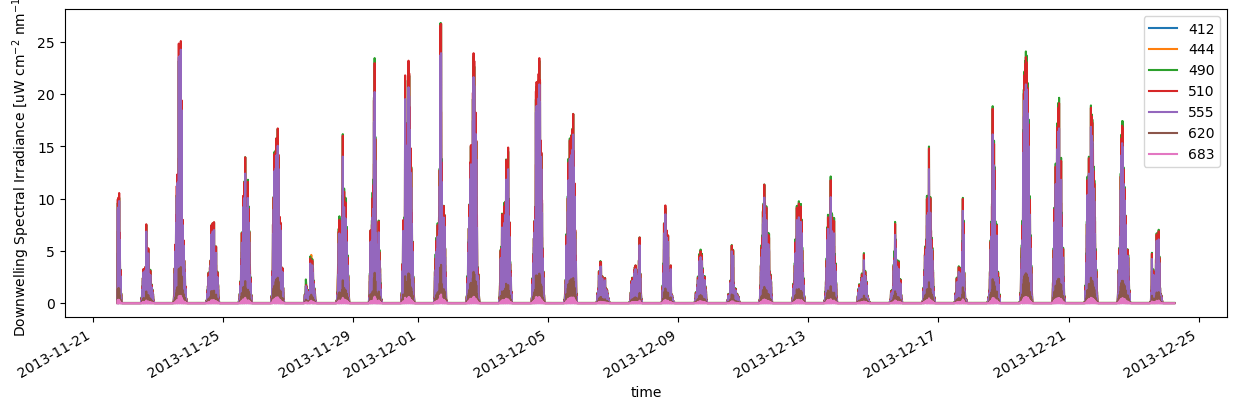

In [84]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

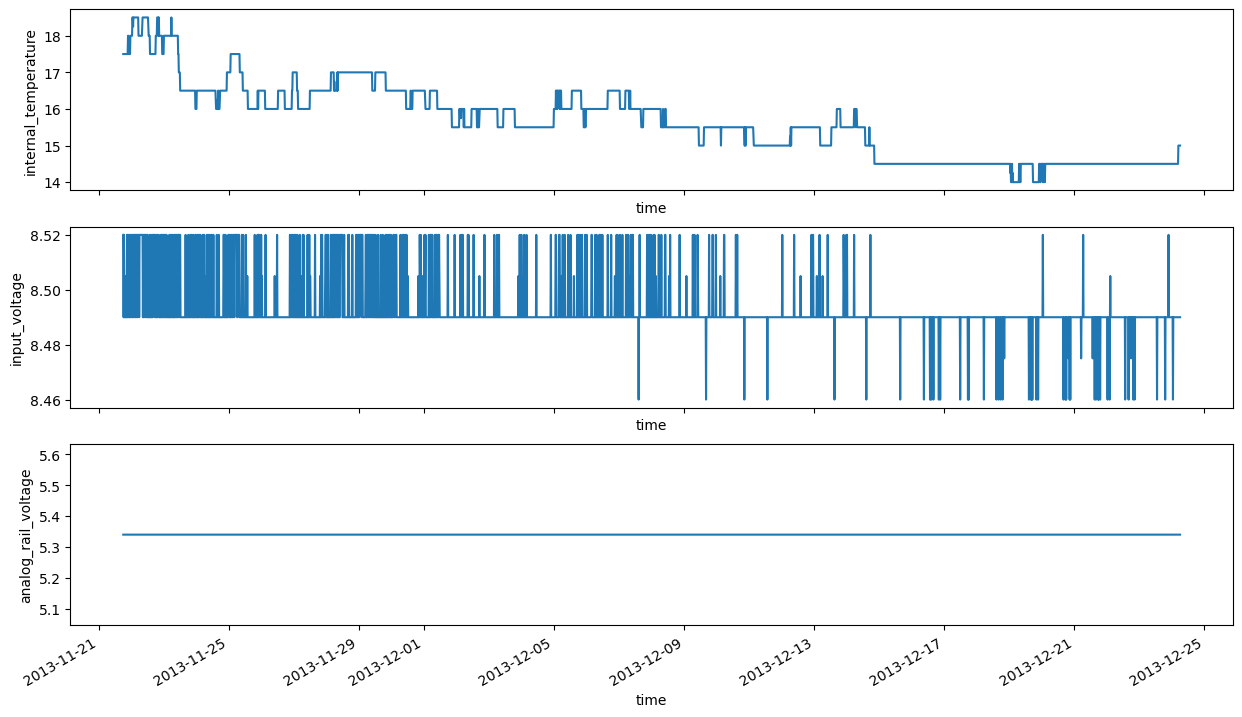

In [85]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

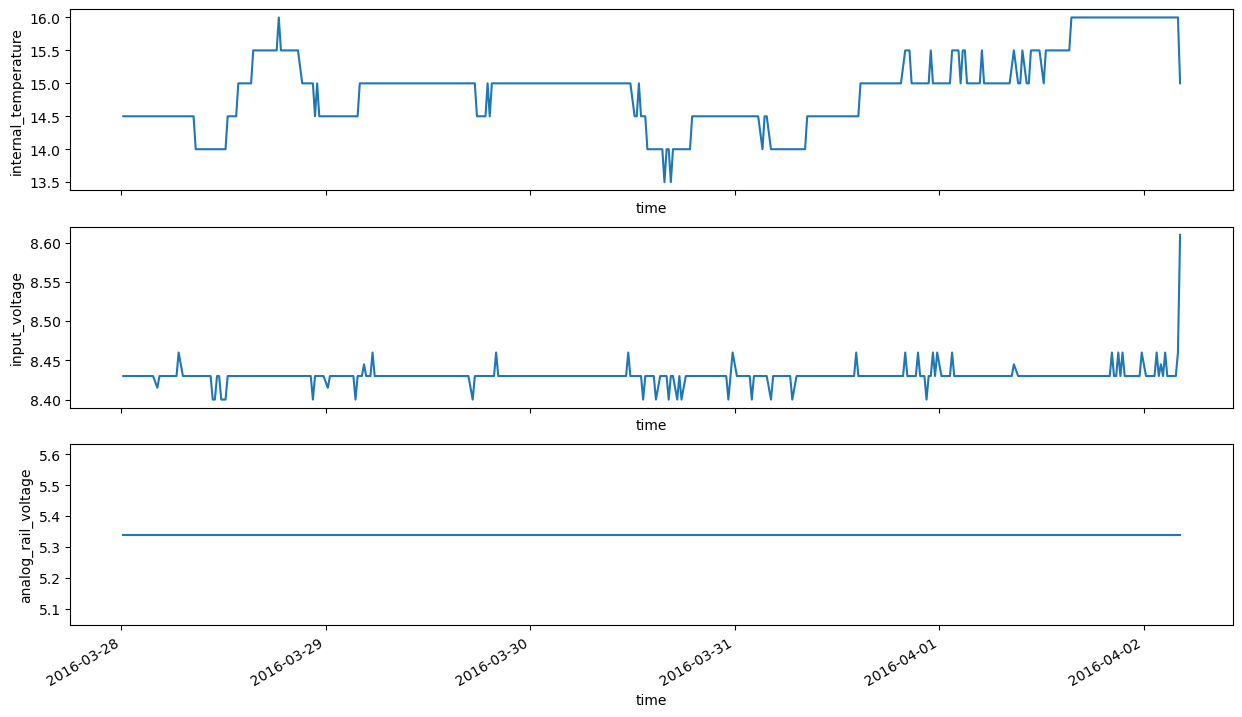

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 4

In [20]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 4

In [21]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


In [22]:
# Don't run code in this cell for this deployment because current QC flag for existing annotation drops most/all data
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [23]:
annotations['annotation'][0]

'Data not telemetered.'

In [24]:
spkir = nanfill_time_gaps(spkir)

In [25]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 13409, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2015-10-23T19:15:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 nan nan ... nan nan
    input_voltage                  (station, time) float32 nan nan ... nan nan
    deployment                     (station, time) float32 nan nan ... nan nan
    analog_rail_voltage            (station, time) float32 nan nan ... nan nan
    raw_irradiance_412             (station, time) float32 nan nan ... nan nan
    raw_irradiance_444             (station, time) float32 nan nan ... nan nan
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 nan nan ... nan nan
    rollup_annotations_qc_results  (station, time) float32 nan nan ... nan nan
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.13
    lon                            (station) float32 -70.78
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

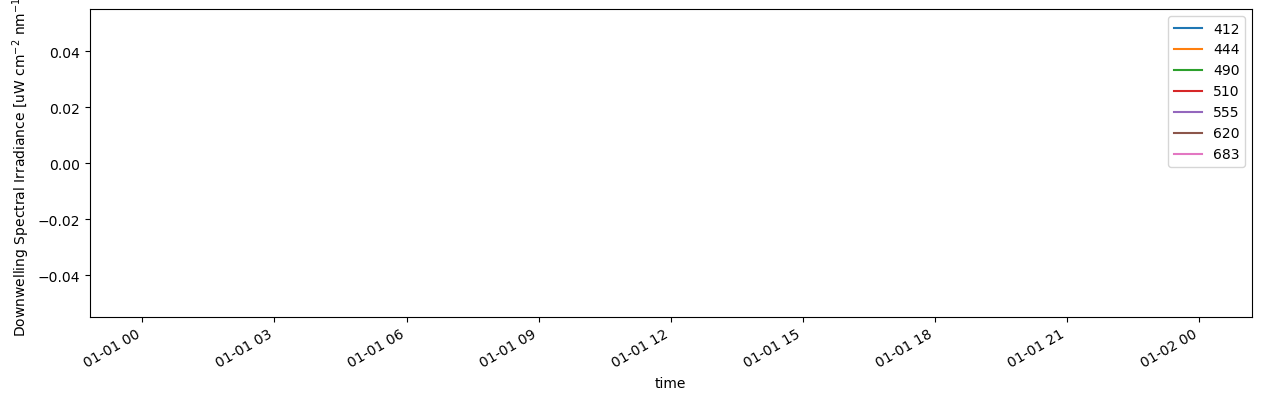

In [26]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

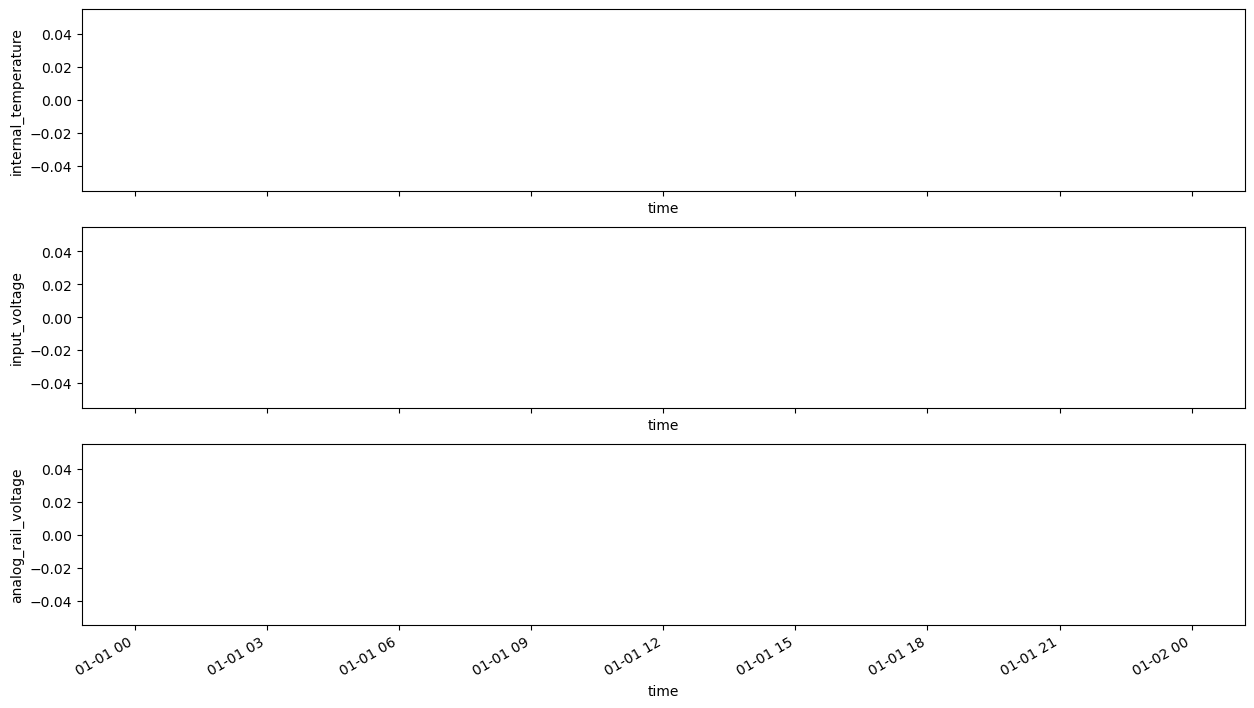

In [27]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

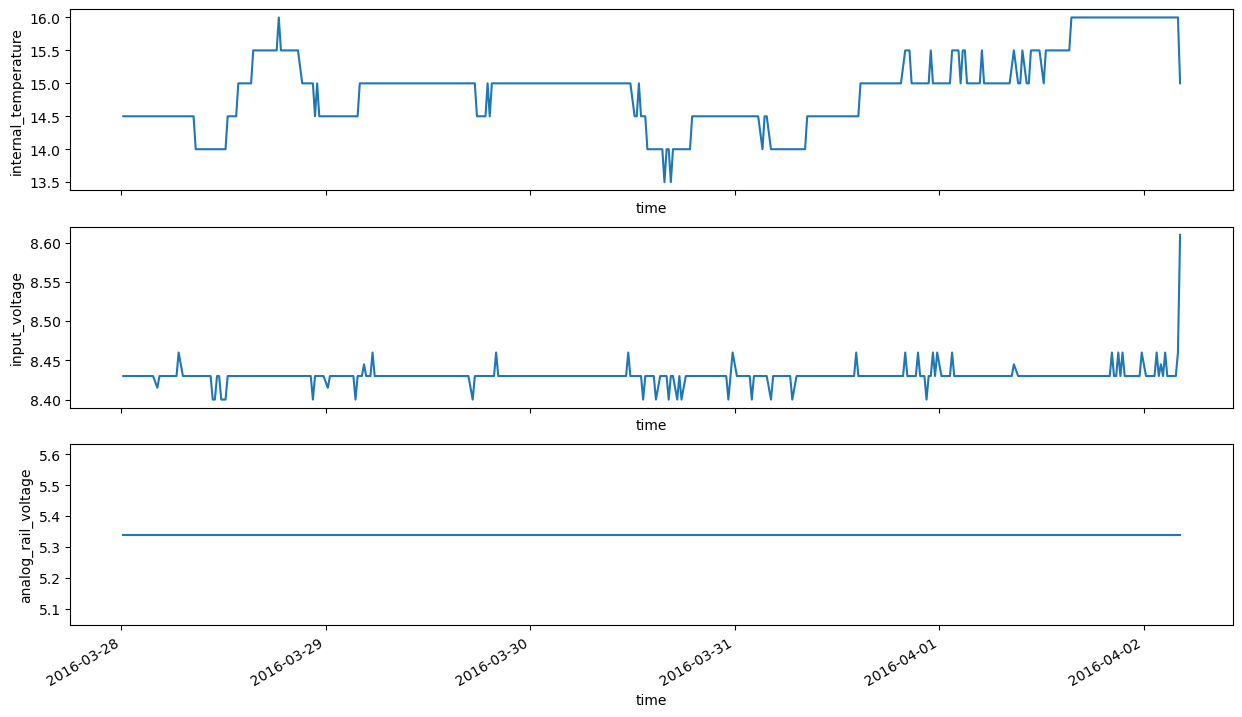

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 5

In [25]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 5

In [26]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


In [27]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [28]:
spkir = nanfill_time_gaps(spkir)

In [29]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 12922, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2016-05-13T14:00:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 12.0 12.0 ... 25.5
    input_voltage                  (station, time) float32 8.43 8.43 ... 8.52
    deployment                     (station, time) float32 5.0 5.0 ... 5.0 5.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.34
    raw_irradiance_412             (station, time) float32 2.205e+09 ... 2.15...
    raw_irradiance_444             (station, time) float32 2.219e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 1.077 ... 0.3232
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.14
    lon                            (station) float32 -70.77
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

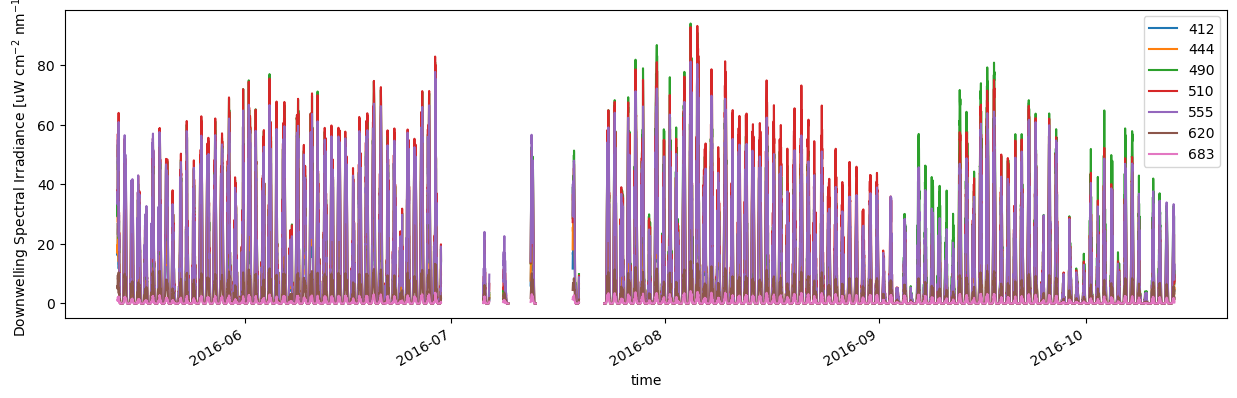

In [30]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

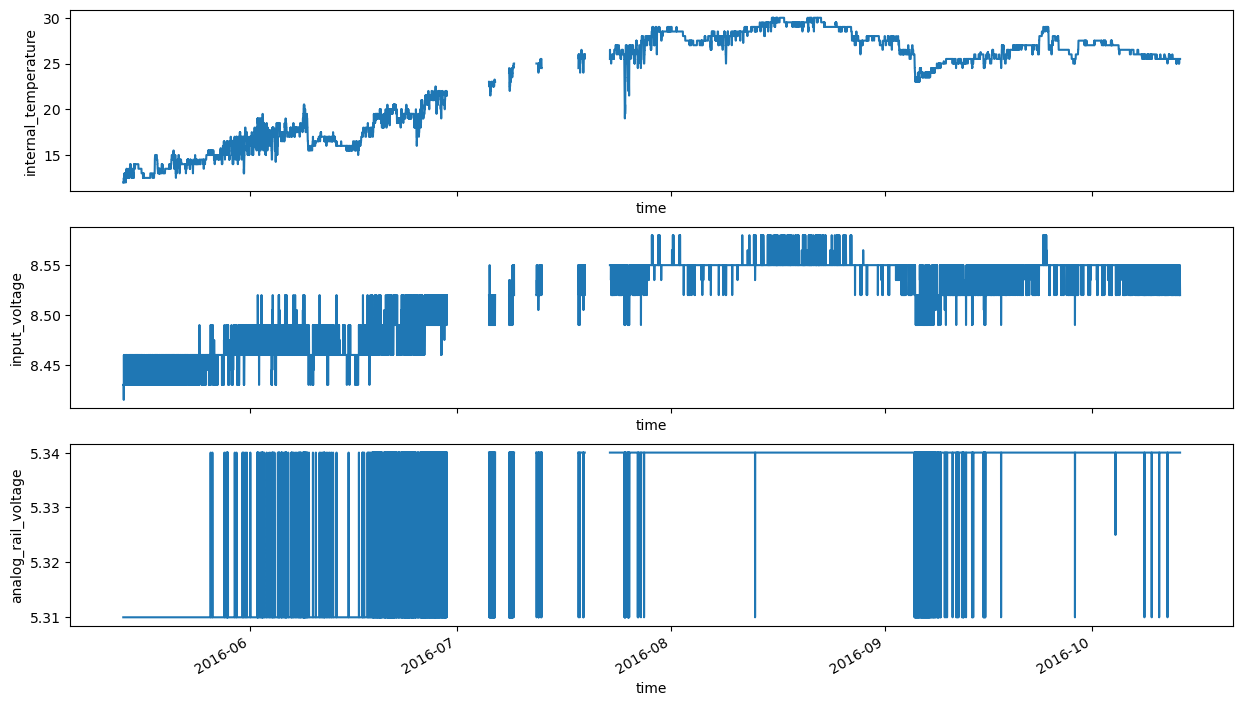

In [31]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

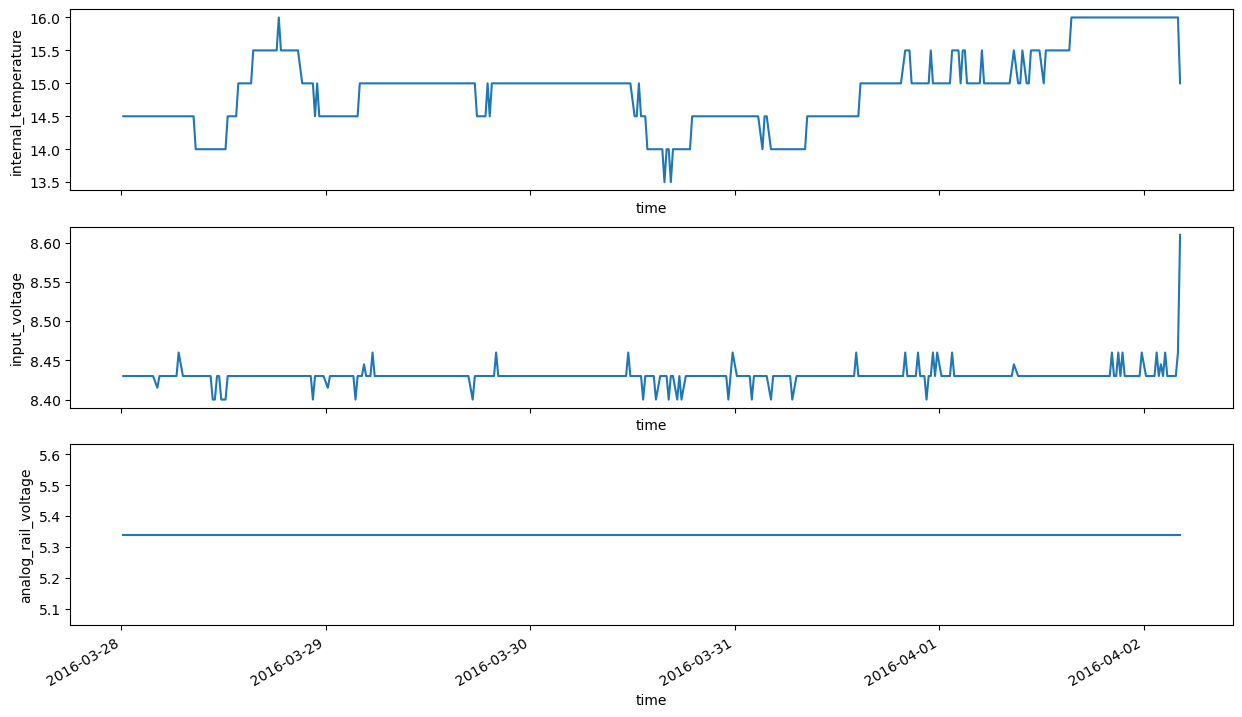

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 6

In [15]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 6

In [16]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


In [17]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [18]:
spkir = nanfill_time_gaps(spkir)

In [19]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 20166, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2016-10-13T18:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 26.5 26.5 ... 21.5
    input_voltage                  (station, time) float32 8.49 8.49 ... 8.46
    deployment                     (station, time) float32 6.0 6.0 ... 6.0 6.0
    analog_rail_voltage            (station, time) float32 5.34 5.34 ... 5.34
    raw_irradiance_412             (station, time) float32 2.219e+09 ... 2.14...
    raw_irradiance_444             (station, time) float32 2.233e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.6269 ... 0.04401
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.13
    lon                            (station) float32 -70.78
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

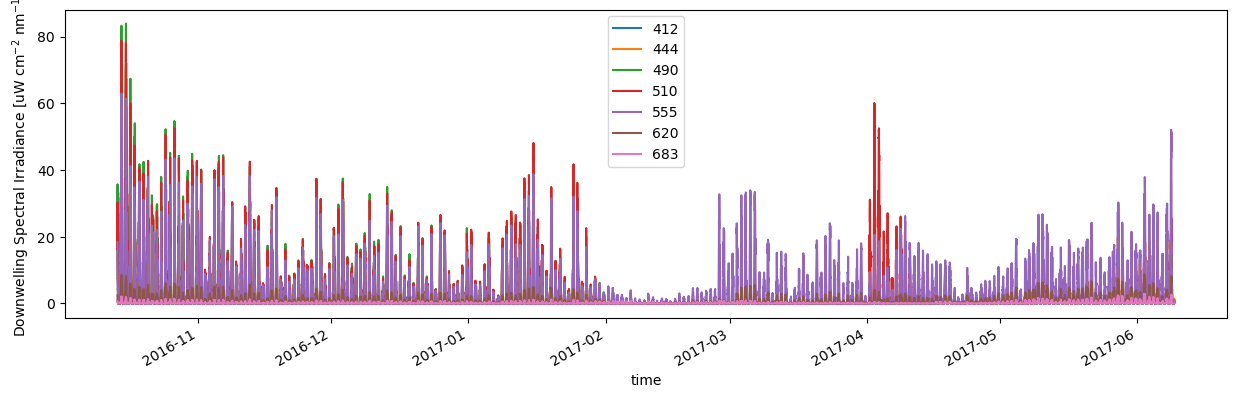

In [20]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

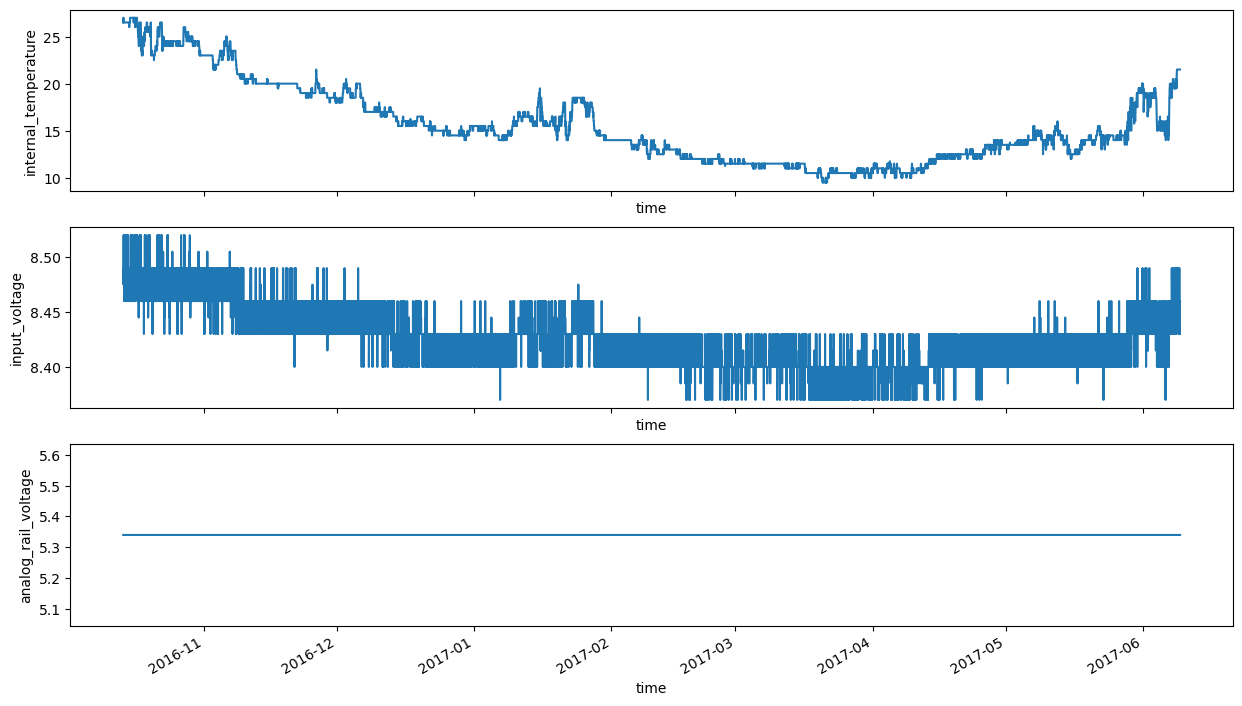

In [21]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

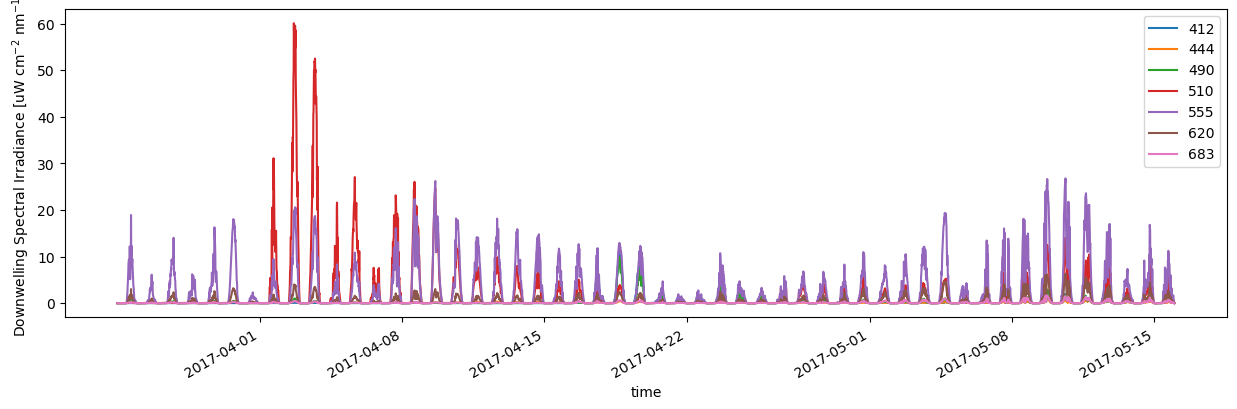

In [22]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2017-03-25','2017-05-15')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

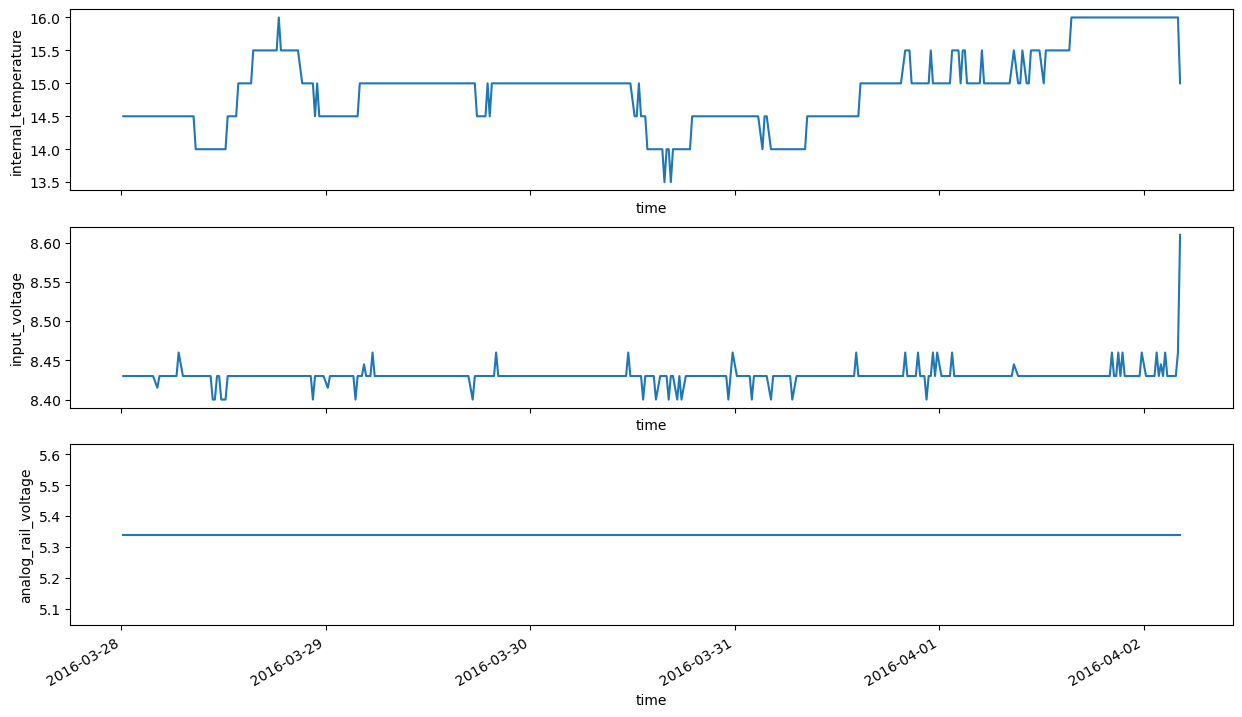

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 7

In [39]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 7

In [40]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


In [41]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [42]:
spkir = nanfill_time_gaps(spkir)

In [43]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 12527, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2017-06-09T14:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 18.0 17.5 ... 23.0
    input_voltage                  (station, time) float32 8.49 8.49 ... 8.49
    deployment                     (station, time) float32 7.0 7.0 ... 7.0 7.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.276e+09 ... 2.15...
    raw_irradiance_444             (station, time) float32 2.337e+09 ... 2.15...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 2.454 ... 0.05656
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.14
    lon                            (station) float32 -70.77
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

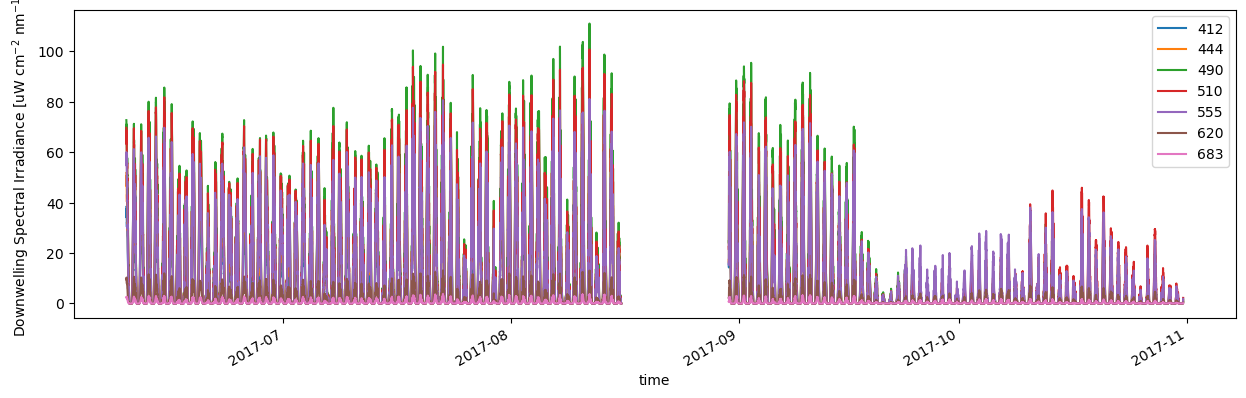

In [44]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

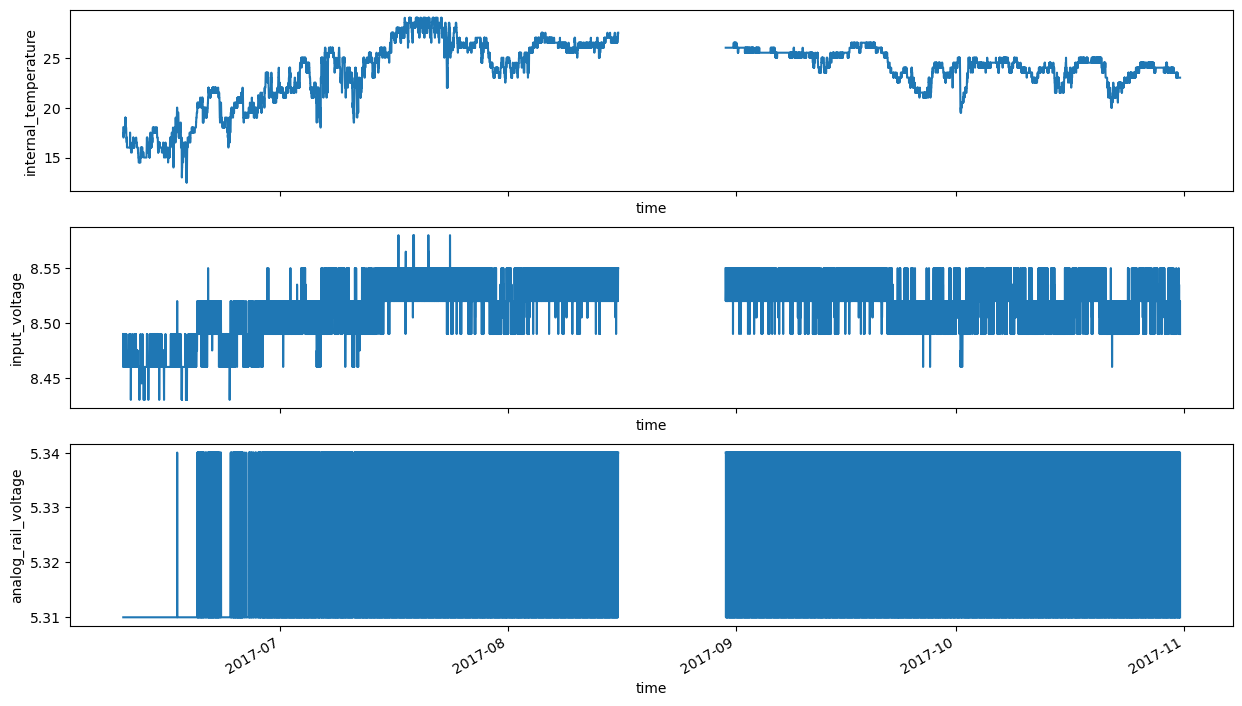

In [45]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

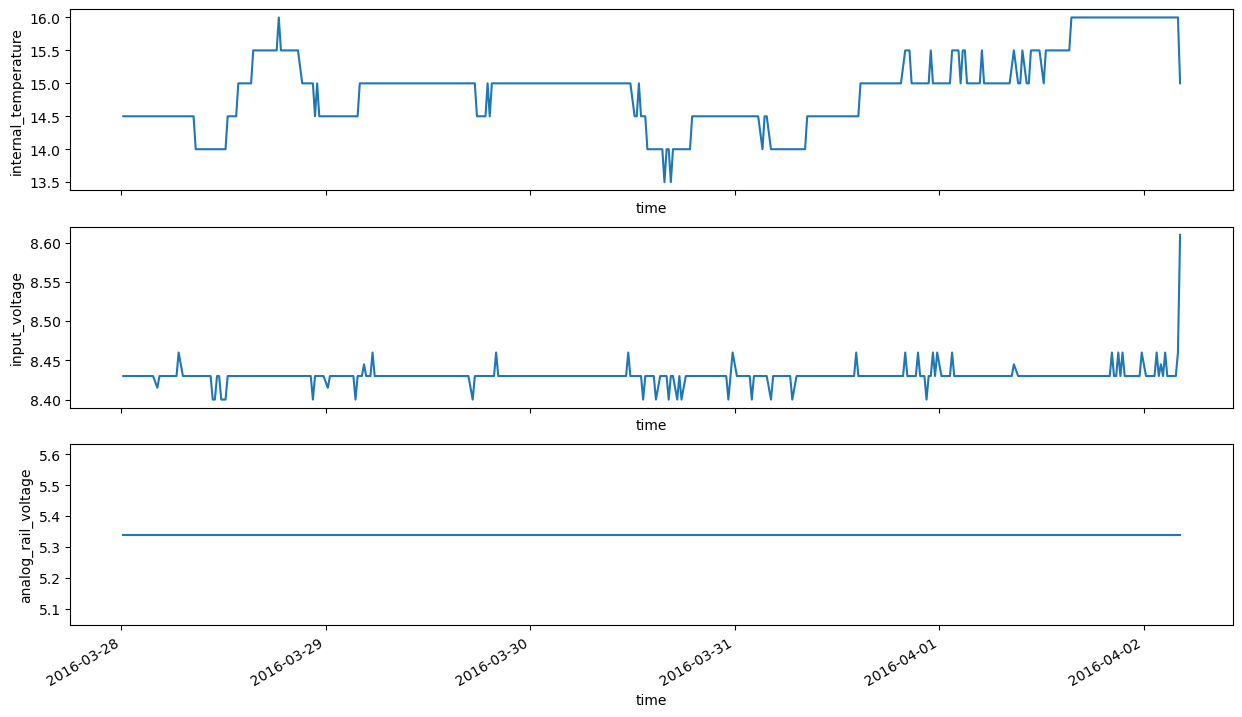

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 10

In [46]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 10

In [47]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


In [48]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [49]:
spkir = nanfill_time_gaps(spkir)

In [50]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 15311, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2018-10-30T01:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 nan 15.5 ... 8.0 8.0
    input_voltage                  (station, time) float32 nan 8.43 ... 8.37
    deployment                     (station, time) float32 nan 10.0 ... 10.0
    analog_rail_voltage            (station, time) float32 nan 5.34 ... 5.34
    raw_irradiance_412             (station, time) float32 nan ... 2.153e+09
    raw_irradiance_444             (station, time) float32 nan ... 2.15e+09
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 nan ... 0.1809
    rollup_annotations_qc_results  (station, time) float32 nan 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.13
    lon                            (station) float32 -70.78
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

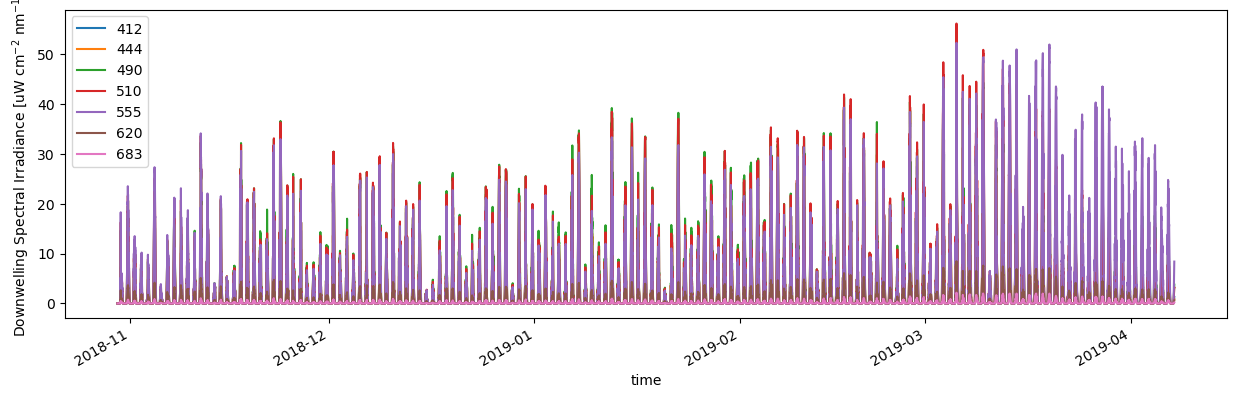

In [51]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

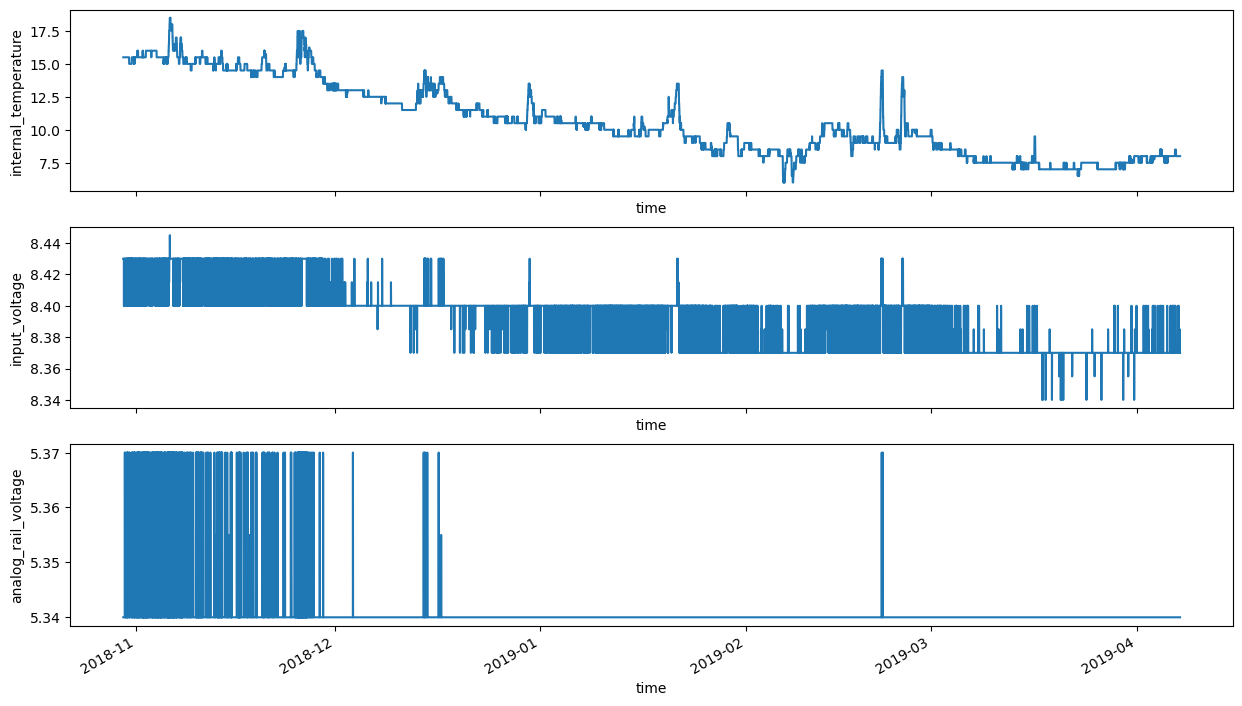

In [52]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

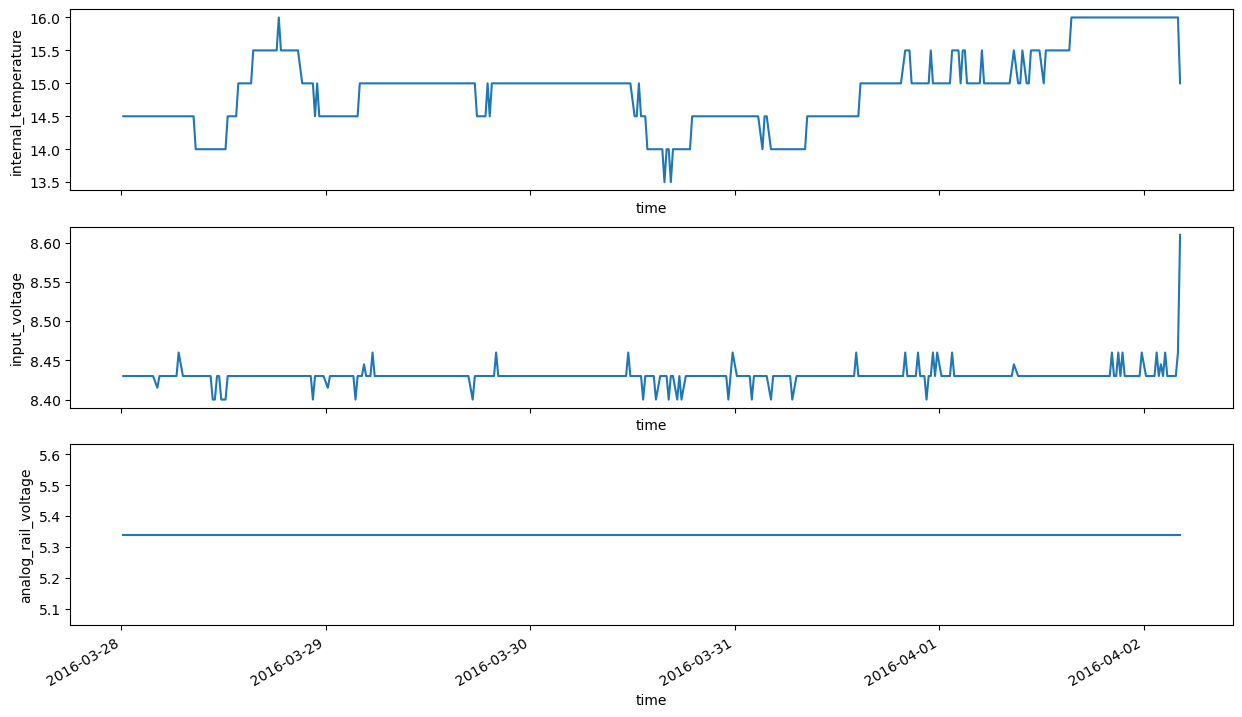

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 11

In [53]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 11

In [54]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


In [55]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [56]:
spkir = nanfill_time_gaps(spkir)

In [57]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 15982, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2019-04-06T14:45:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 10.5 10.5 ... 28.0
    input_voltage                  (station, time) float32 8.31 8.34 ... 8.4
    deployment                     (station, time) float32 11.0 11.0 ... 11.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.31
    raw_irradiance_412             (station, time) float32 2.216e+09 ... 2.19...
    raw_irradiance_444             (station, time) float32 2.255e+09 ... 2.19...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 1.671 ... 0.4609
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.14
    lon                            (station) float32 -70.77
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

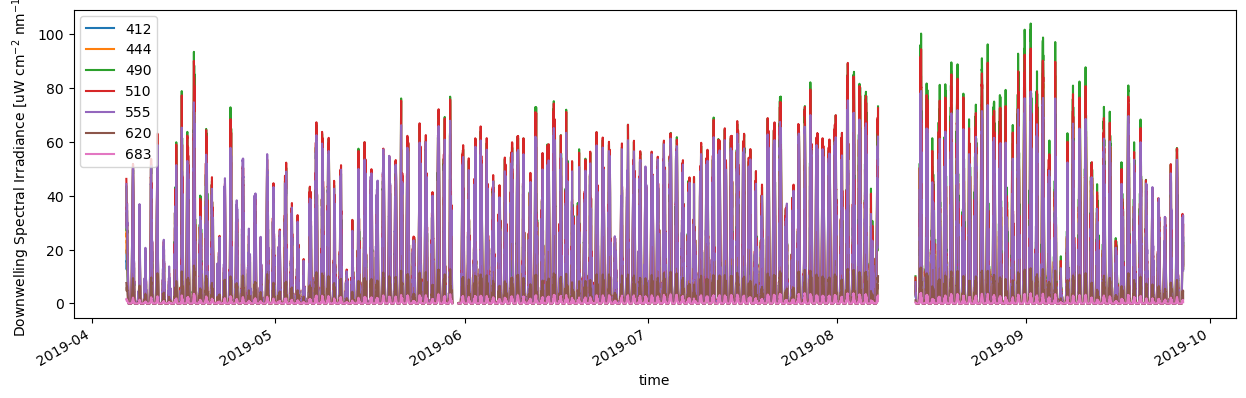

In [58]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

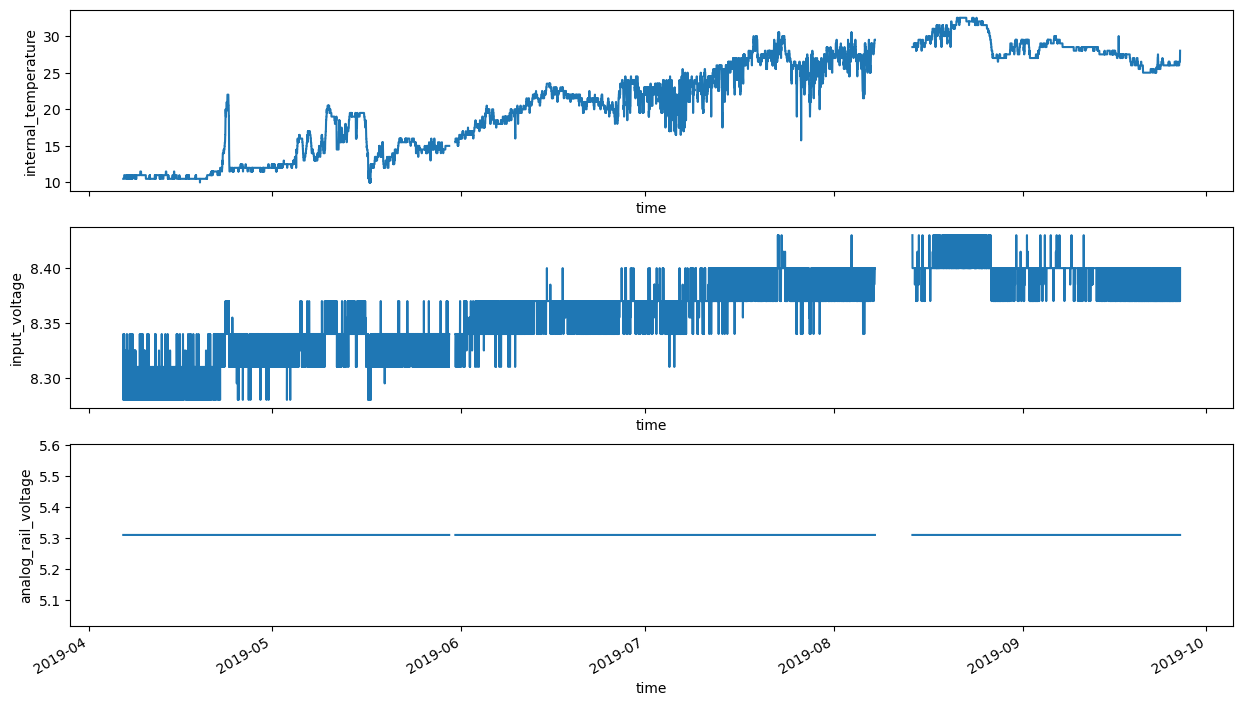

In [59]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

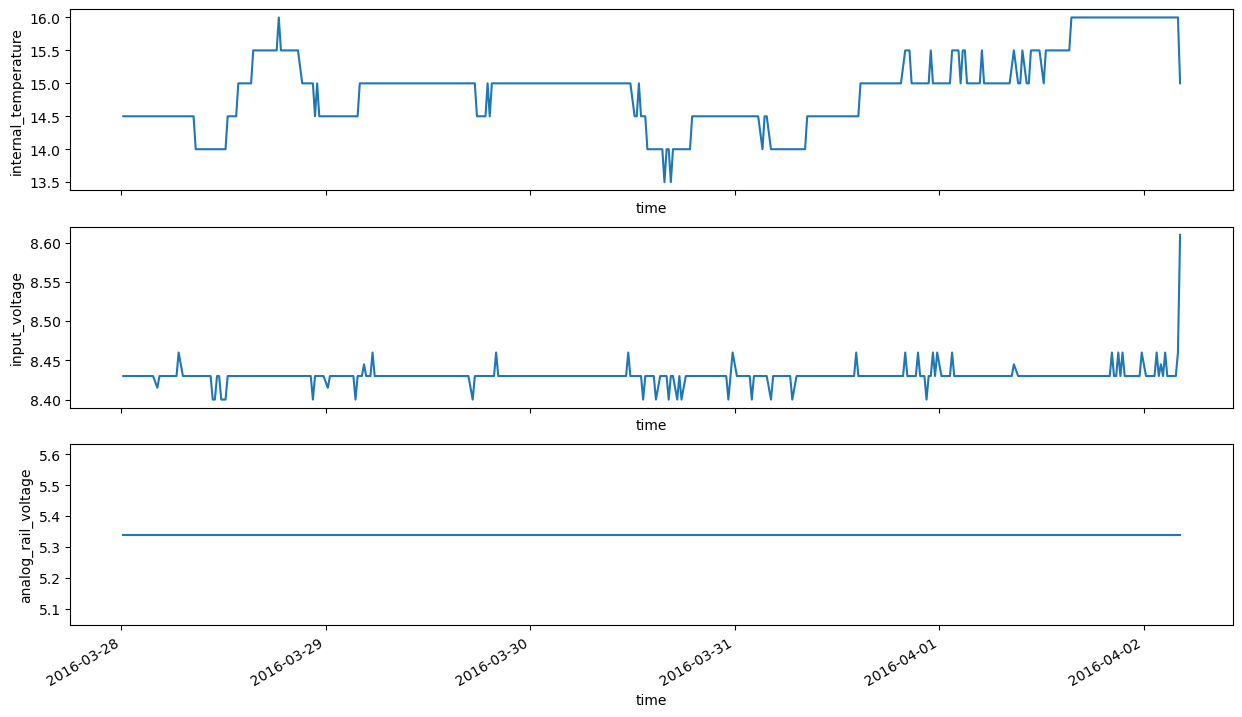

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Deployment 16

In [60]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 16

In [61]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


In [62]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [63]:
spkir = nanfill_time_gaps(spkir)

In [64]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 14879, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2022-04-13T11:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 14.0 14.0 ... nan nan
    input_voltage                  (station, time) float32 8.4 8.4 ... nan nan
    deployment                     (station, time) float32 16.0 16.0 ... nan nan
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... nan nan
    raw_irradiance_412             (station, time) float32 2.155e+09 ... nan
    raw_irradiance_444             (station, time) float32 2.158e+09 ... nan
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.1203 0.1775 ... nan
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... nan nan
    station_name                   (station) <U8 'CP01CNSM'
    lat                            (station) float32 40.13
    lon                            (station) float32 -70.78
    z                              (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

In [23]:
# Print message for annotation about UV light failing
annotations['annotation'][9]

'Deployment 16: The UV light failured during the deployment.  The instrument face was found to be biofouled on recovery.'

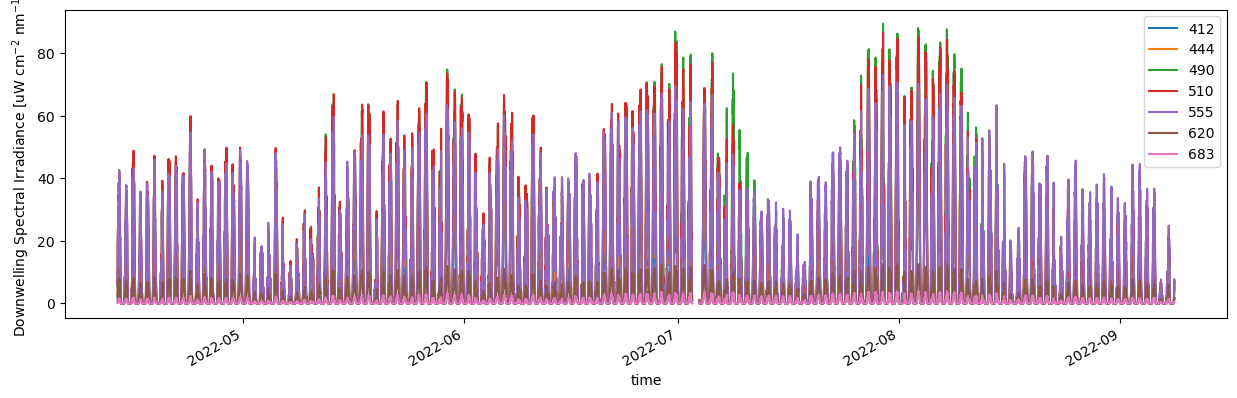

In [65]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

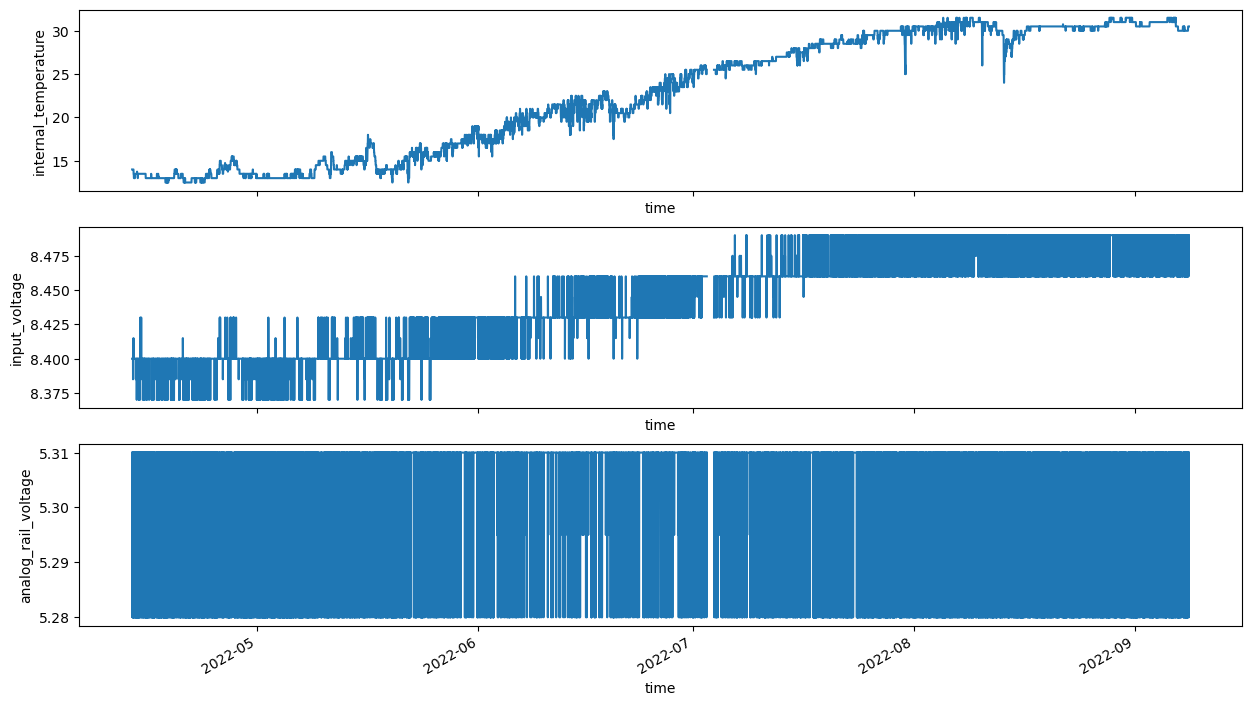

In [66]:
#  Checking internal temperature, supply voltage, and analog rail voltage during the deployment
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

In [ ]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2016-03-28','2016-04-04')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

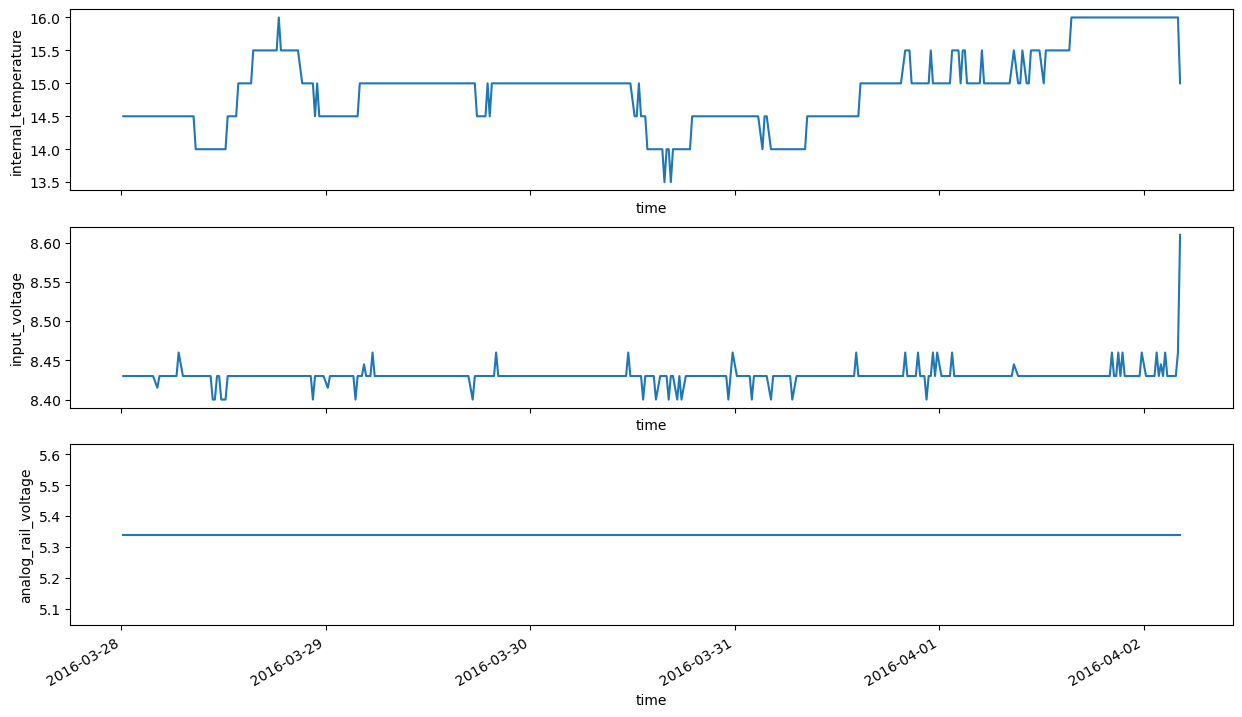

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

### Histograms of downwelling irradiance measurements

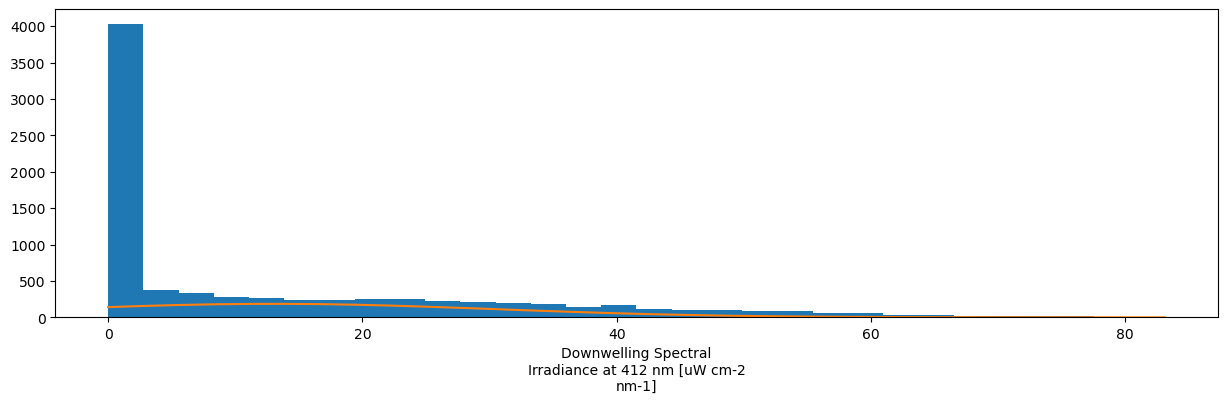

In [30]:
# histogram of downwelling irradiance @ 412 nm variable
irrad412 = spkir['downwelling_irradiance_412'][0]
# irrad412 = spkir['downwelling_irradiance_412'][0].sel(time=slice('2017-07-01'))
mu412 = irrad412.mean()
sig412 = irrad412.std()

plt.figure(figsize=(15,4))
c, x, h = irrad412.plot.hist(bins=30)
norm412 = sum(c)*norm.pdf(x, mu412, sig412)
plt.plot(x, norm412)

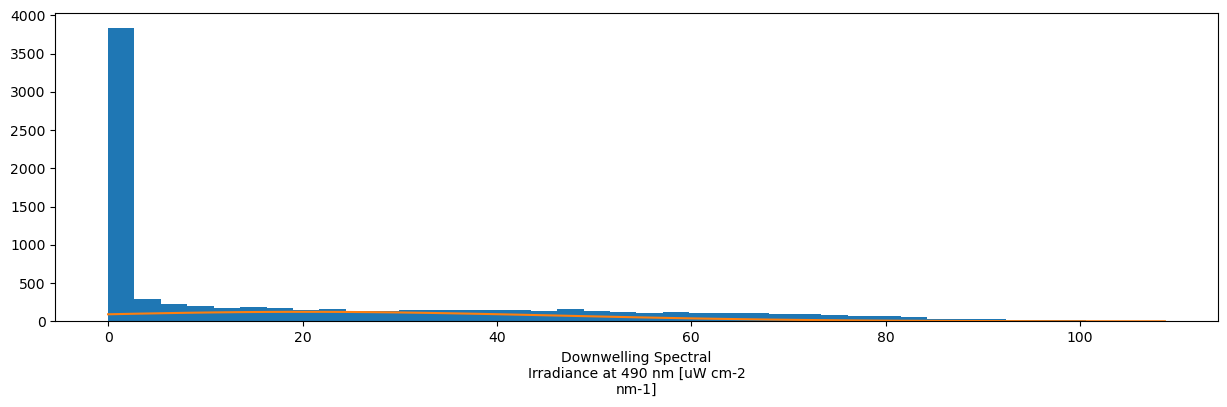

In [31]:
# histogram of downwelling irradiance @ 490 nm variable
irrad490 = spkir['downwelling_irradiance_490'][0]
# irrad490 = spkir['downwelling_irradiance_490'][0].sel(time=slice('2017-07-01'))
mu490 = irrad490.mean()
sig490 = irrad490.std()

plt.figure(figsize=(15,4))
c, x, h = irrad490.plot.hist(bins=40)
norm490 = sum(c)*norm.pdf(x, mu490, sig490)
plt.plot(x, norm490)

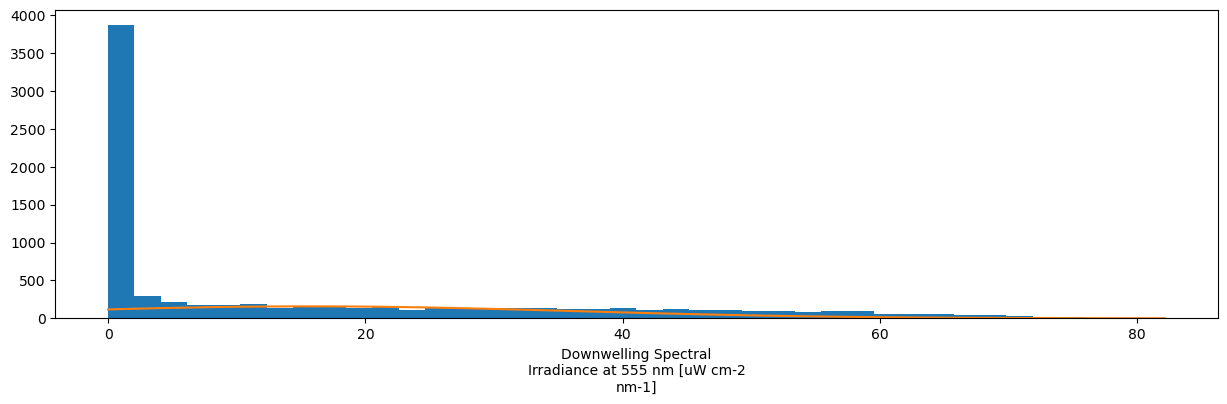

In [32]:
# histogram of downwelling irradiance @ 555 nm variable
irrad555 = spkir['downwelling_irradiance_555'][0]
# irrad555 = spkir['downwelling_irradiance_555'][0].sel(time=slice('2015-06-01'))
mu555 = irrad555.mean()
sig555 = irrad555.std()

plt.figure(figsize=(15,4))
c, x, h = irrad555.plot.hist(bins=40)
norm555 = sum(c)*norm.pdf(x, mu555, sig555)
plt.plot(x, norm555)

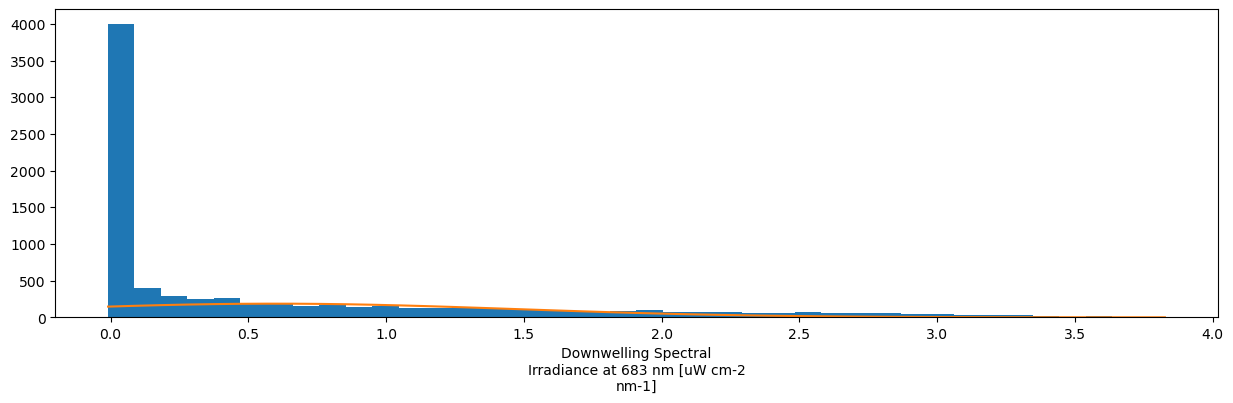

In [33]:
# histogram of downwelling irradiance @ 683 nm variable
irrad683 = spkir['downwelling_irradiance_683'][0]
# irrad683 = spkir['downwelling_irradiance_683'][0].sel(time=slice('2017-07-01'))
mu683 = irrad683.mean()
sig683 = irrad683.std()

plt.figure(figsize=(15,4))
c, x, h = irrad683.plot.hist(bins=40)
norm683 = 0.05*sum(c)*norm.pdf(x, mu683, sig683)
plt.plot(x, norm683)

In [34]:
# concat the different irradiance variables for histogram of all irradiance values
irradAll = xr.DataArray()
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        irradAll = xr.concat([irradAll, spkir[var][0]], dim='channel')
irradAll

<xarray.DataArray (channel: 8, time: 8581)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-1.24489265e-02, -1.22679379e-02, -1.27385072e-02, ...,
         3.33838081e+01,  2.91790657e+01,  2.71376114e+01],
       [-2.28602290e-02, -2.30053701e-02, -2.28148736e-02, ...,
         4.15520287e+01,  3.64205742e+01,  3.37744560e+01],
       ...,
       [-8.62311665e-03, -7.81955104e-03, -8.97590257e-03, ...,
         3.88252945e+01,  3.34404564e+01,  3.07892475e+01],
       [ 1.19705470e-02,  1.19244633e-02,  1.15373600e-02, ...,
         4.89614058e+00,  4.12962008e+00,  3.72692156e+00],
       [-4.96644620e-03, -5.32475766e-03, -4.51855734e-03, ...,
         1.25258076e+00,  1.05488253e+00,  9.43447709e-01]])
Coordinates:
  * time     (time) datetime64[ns] 2015-05-09T01:00:00 ... 2015-09-28T19:45:00
Dimensions without coordinates: channel

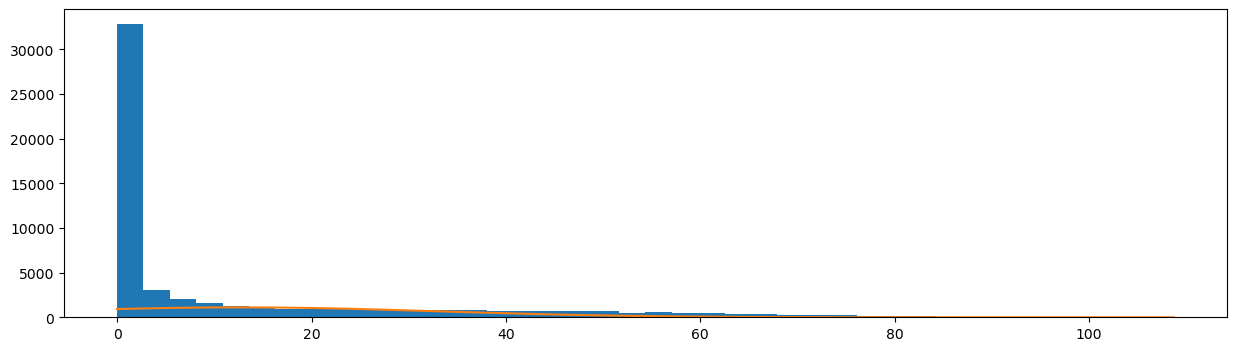

In [35]:
# histogram using all irradiance values
radAll= irradAll
muAll = radAll.mean()
sigAll = radAll.std()

plt.figure(figsize=(15,4))
c, x, h = radAll.plot.hist(bins=40)
normAll = sum(c)*norm.pdf(x, muAll, sigAll)
plt.plot(x, normAll)

### Histograms after monthly mean filter

### Spectrograms of downwelling irradiance (not burst averaged)

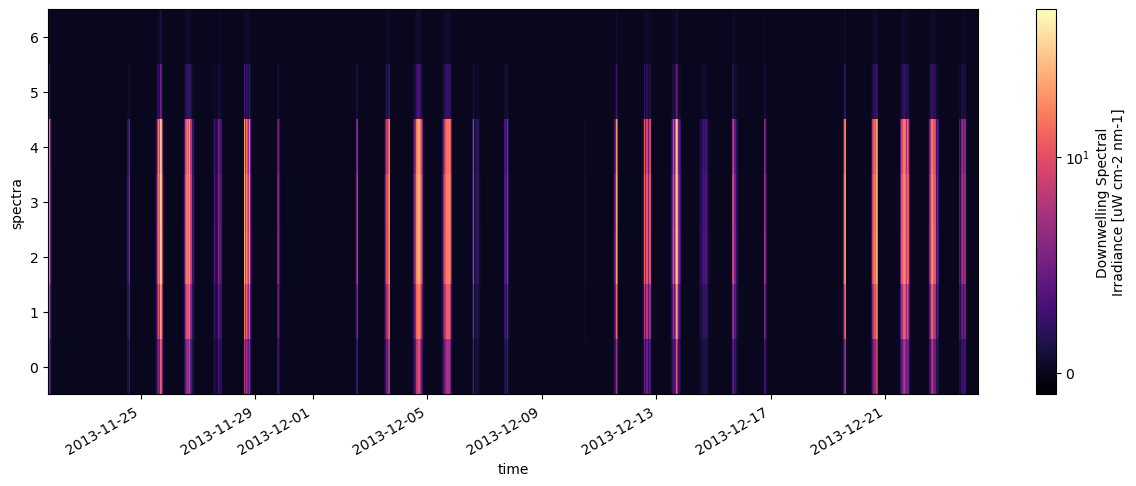

In [20]:
# Trying same plot with full resolution data with log-scale colormap (linear between -1,10)
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [28]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

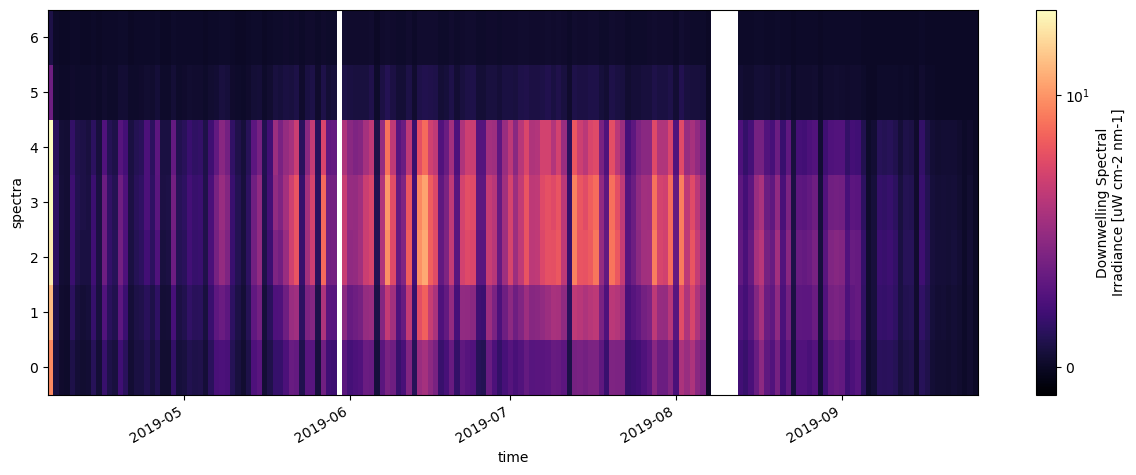

In [30]:
# pcolormesh plot with log-scale cmap except for [-1, 10] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [31]:
# Now lets try this with a 5-day median resample
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="5D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 35, spectra: 7)>
array([[6.82127204e-01, 9.39339140e-01, 1.49556243e+00, 1.66573864e+00,
        1.50775647e+00, 2.17019475e-01, 6.62599682e-02],
       [4.09351526e-01, 5.97971766e-01, 8.23282033e-01, 8.41685295e-01,
        7.24953008e-01, 1.07756459e-01, 4.46083474e-02],
       [1.11149060e+00, 1.63481436e+00, 2.06272259e+00, 1.99825457e+00,
        1.42778278e+00, 2.07900504e-01, 6.89136231e-02],
       [6.33905790e-01, 8.30168475e-01, 1.26737414e+00, 1.37036116e+00,
        1.22211412e+00, 1.81988724e-01, 5.88591173e-02],
       [4.88950510e-01, 7.05335209e-01, 1.08804481e+00, 1.18094031e+00,
        1.09429885e+00, 1.71634988e-01, 5.71144999e-02],
       [6.95715056e-01, 9.77443677e-01, 1.34453113e+00, 1.40168619e+00,
        1.25158622e+00, 1.94583331e-01, 6.10077514e-02],
       [1.77887788e+00, 2.40299210e+00, 3.25211386e+00, 3.32345650e+00,
        2.82799702e+00, 3.63398624e-01, 9.33474496e-02],
       [8.35149703e-01, 1.11870379e+00, 1.48298037e+00, 1.51192503e+00,
        1.28393037e+00, 1.92699171e-01, 5.95294177e-02],
       [1.19328147e+00, 1.70288643e+00, 2.52271664e+00, 2.78847411e+00,
        2.70395010e+00, 3.80136554e-01, 1.00454470e-01],
       [2.62830054e+00, 3.91435216e+00, 5.20132994e+00, 5.24724249e+00,
        4.42306642e+00, 5.73875815e-01, 1.45943075e-01],
...
       [2.06008457e+00, 2.58632186e+00, 3.16383481e+00, 2.98038643e+00,
        2.42941038e+00, 3.60160794e-01, 9.68550489e-02],
       [2.74753531e+00, 3.09858421e+00, 3.49182410e+00, 3.13586101e+00,
        2.39268108e+00, 3.07221372e-01, 8.25675502e-02],
       [2.20276612e+00, 2.58443371e+00, 2.88604360e+00, 2.58521177e+00,
        1.98243281e+00, 2.43159916e-01, 6.05670060e-02],
       [1.66826512e+00, 2.02154214e+00, 2.23259445e+00, 1.97611683e+00,
        1.40635816e+00, 1.69531314e-01, 4.33503864e-02],
       [2.70608963e+00, 3.34031155e+00, 3.58219552e+00, 3.11022829e+00,
        2.22732694e+00, 2.56595992e-01, 6.27982799e-02],
       [7.45937359e-01, 8.52196817e-01, 9.00792402e-01, 7.83724039e-01,
        6.10910023e-01, 8.67380087e-02, 2.31770994e-02],
       [1.05503826e+00, 1.35776975e+00, 1.46589740e+00, 1.28284831e+00,
        9.28877248e-01, 1.16683356e-01, 3.63260056e-02],
       [7.11412936e-01, 9.11214792e-01, 1.05646410e+00, 9.39103459e-01,
        7.16780233e-01, 8.74880143e-02, 2.91914385e-02],
       [3.15291575e-01, 3.98664721e-01, 4.91061523e-01, 4.47583359e-01,
        3.45641780e-01, 4.67864891e-02, 1.80901622e-02],
       [6.95465087e-03, 5.62515071e-03, 3.77377740e-03, 2.68314116e-03,
        3.17550394e-03, 3.19469816e-03, 4.37195968e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-11 ... 2019-09-23
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

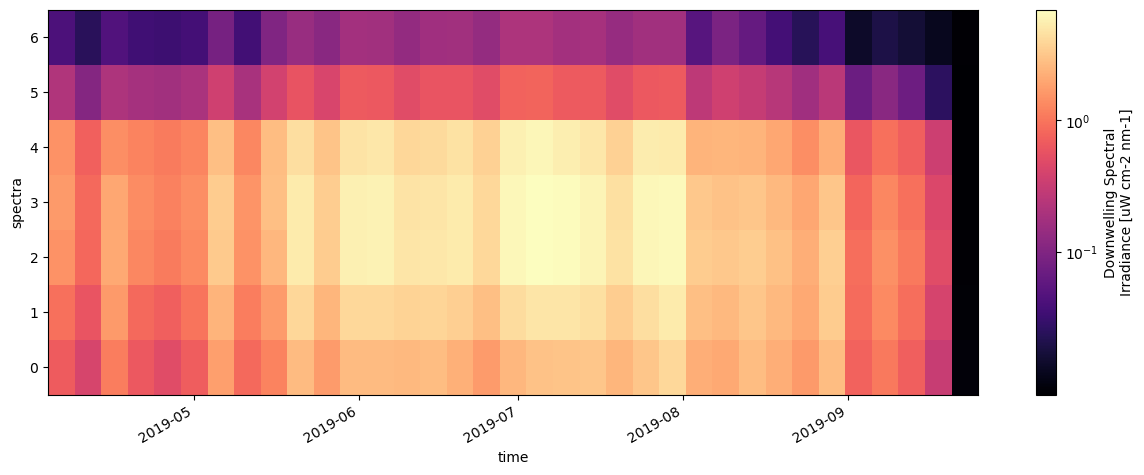

In [37]:
# 5-day median of downwelling spectral irradiance pcolormesh plot with log-scale cmap except for [0, 0.01] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=0.1))